In [93]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2,SelectKBest,SelectPercentile
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score,  recall_score, f1_score, average_precision_score, confusion_matrix, precision_score, precision_recall_curve, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import joblib 
import urllib3



### Find labeled dataset below

In [94]:
!ls ../data/*.xlsx
#df=pd.read_excel('../data/results_merged_df_labeled3.xlsx')
#df=df[df['email'].isnull()==False]
#df.to_excel('../data/results_merged_df_labeled4.xlsx')
df=pd.read_excel('../data/results_merged_df_labeled4.xlsx') 
df['label'].value_counts()

../data/results_merged_df.xlsx          ../data/results_merged_df_labeled3.xlsx
../data/results_merged_df_labeled.xlsx  ../data/results_merged_df_labeled4.xlsx
../data/results_merged_df_labeled2.xlsx


label
0    2404
1     391
Name: count, dtype: int64

In [95]:
mdls=['mistral_score','openhermes_score','vicuna_score','gemma_score','search_phrase','label']
df[mdls].groupby('search_phrase').mean().sort_values('label',ascending=False)

,mistral_score,openhermes_score,vicuna_score,gemma_score,label
search_phrase,,,,,
it appears that some Enron employees used dummy accounts and rigged valuation methodologies to create false profit-and-loss entries for the derivatives,2.876833,3.043988,12.665689,3.994135,0.583578
record keeping accounting practices,1.052117,1.214984,6.211726,2.771987,0.254072
mark to market accounting practices,0.537255,1.341176,5.843137,2.180392,0.180392
raptor creation of special purpose entities,0.408304,1.044983,6.006920,2.307958,0.148789
mark to market losses,0.413919,0.706960,5.410256,2.512821,0.036630
RANDOM,0.176692,0.239850,5.409023,1.639098,0.011278


In [62]:
def adj_class(y_scores,t):
    return [1 if y>t else 0 for y in y_scores]   

def find_threshold_at_recall_target(y_true,y_proba,recall_target=0.5,pos_label=1):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    idx=np.argwhere(recalls>=recall_target)
    if len(idx)>0:
        idx=idx.max()
        return thresholds[idx]
    else:
        return np.nan

def precision_recall_curves(y_true,y_proba,threshold=0.5,pos_label=1,title='Precision-Recall Curve',model=''):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    y_pred_adj=adj_class(y_proba,threshold)
    adj_recall=recall_score(y_true,y_pred_adj)
    adj_precision=precision_score(y_true,y_pred_adj)
    fig,(ax_pr, ax_tr, ax_tp)=plt.subplots(ncols=3,figsize=(15,5))
    ax_pr.plot(recalls,precisions)
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.plot([adj_recall],[adj_precision],'ro')
    ax_pr.set_title(f'Precision-Recall Curve {model}')
    ax_tr.plot(thresholds,recalls[:-1])
    ax_tr.set_xlabel('Desctrimation Threshold')
    ax_tr.set_ylabel('Recall') 
    ax_tr.set_title(f'Threshold-Recall Curve {model}')
    ax_tr.vlines(threshold,0,1,linestyles='dashed')
    ax_tp.plot(thresholds,precisions[:-1])
    ax_tp.set_xlabel('Desctrimation Threshold')
    ax_tp.set_ylabel('Precision')
    ax_tp.set_title(f'Threshold-Precision Curve {model}')
    ax_tp.vlines(threshold,0,1,linestyles='dashed')
    plt.title(title)

def confusion_matrix_plot_at_threshold(y_true,y_proba,threshold=0.5,model='d',pos_label=1):
    y_pred_adj=adj_class(y_proba,threshold)
    disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true,y_pred_adj),display_labels=[0,1])
    disp.plot(cmap='Blues')

def curvesplot(y_true,y_proba,model_name='Model'):
    threshold=find_threshold_at_recall_target(y_true,y_proba,recall_target=0.8)
    print(f'{model_name} Threshold: {threshold}')
    y_pred_adj=adj_class(y_proba,threshold)
    print(f'{model_name} recall at threshold: {recall_score(y_true,y_pred_adj)}')
    print(f'{model_name} precision at threshold: {precision_score(y_true,y_pred_adj)}')
    precision_recall_curves(y_true,y_proba,threshold=threshold,pos_label=1,title=f'{model_name} Precision-Recall Curve',model=model_name)
    confusion_matrix_plot_at_threshold(y_true,y_proba,threshold=threshold,model=model_name)

    

mistral Threshold: 0.0
mistral recall at threshold: 0.5473145780051151
mistral precision at threshold: 0.7781818181818182
openhermes Threshold: 0.0
openhermes recall at threshold: 0.7698209718670077
openhermes precision at threshold: 0.5626168224299065
vicuna Threshold: 0.7
vicuna recall at threshold: 0.6982097186700768
vicuna precision at threshold: 0.2938643702906351
gemma Threshold: 0.2
gemma recall at threshold: 0.6214833759590793
gemma precision at threshold: 0.39901477832512317


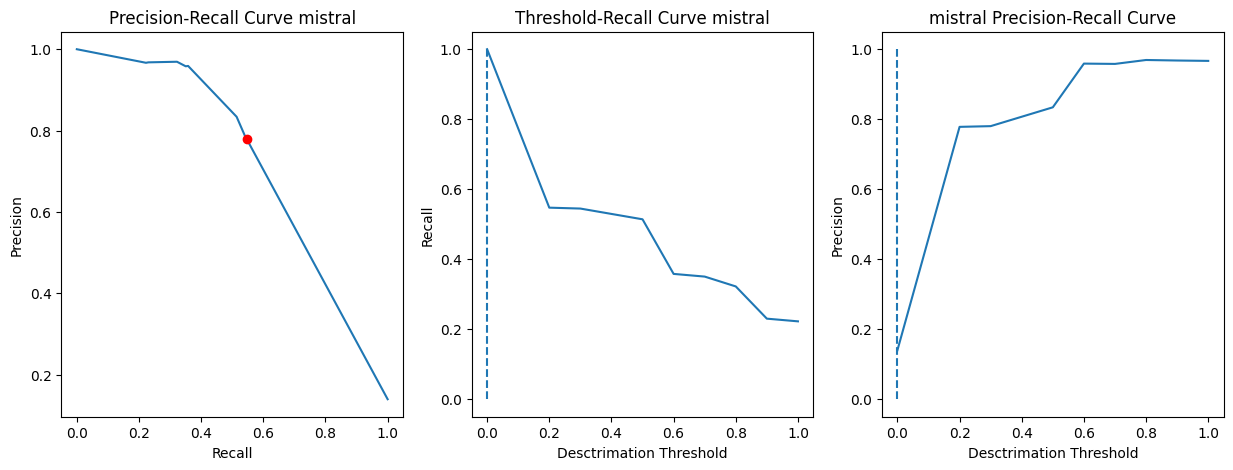

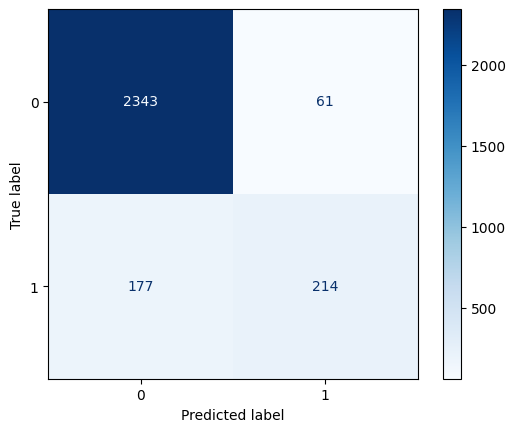

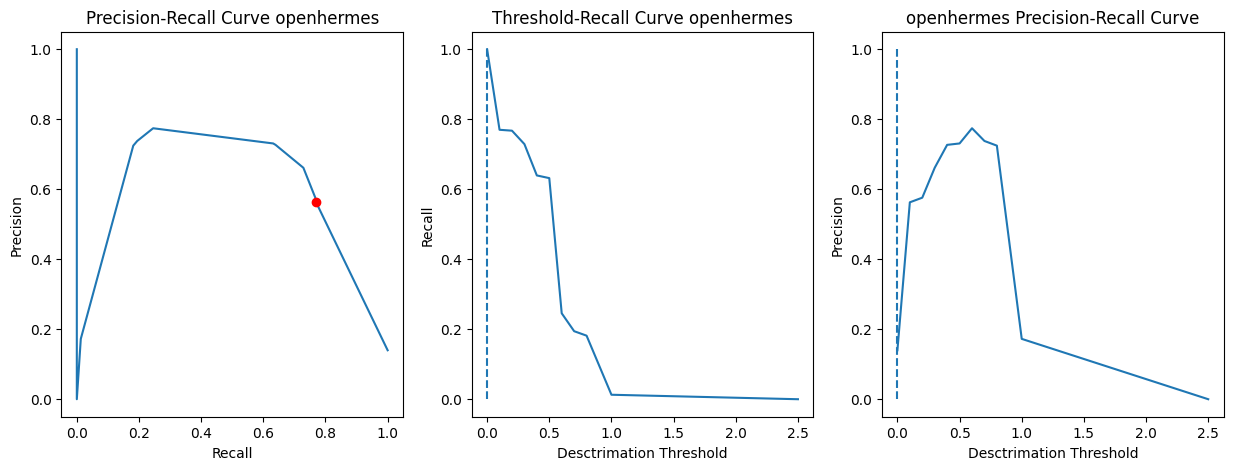

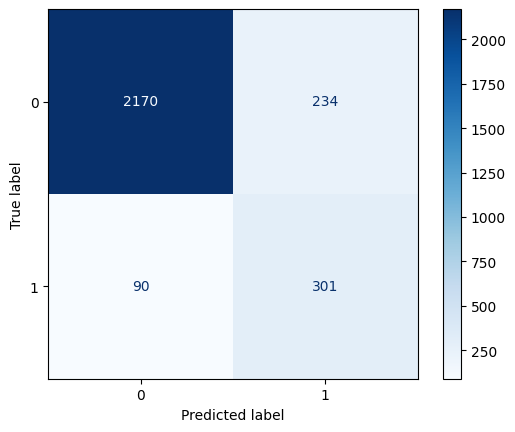

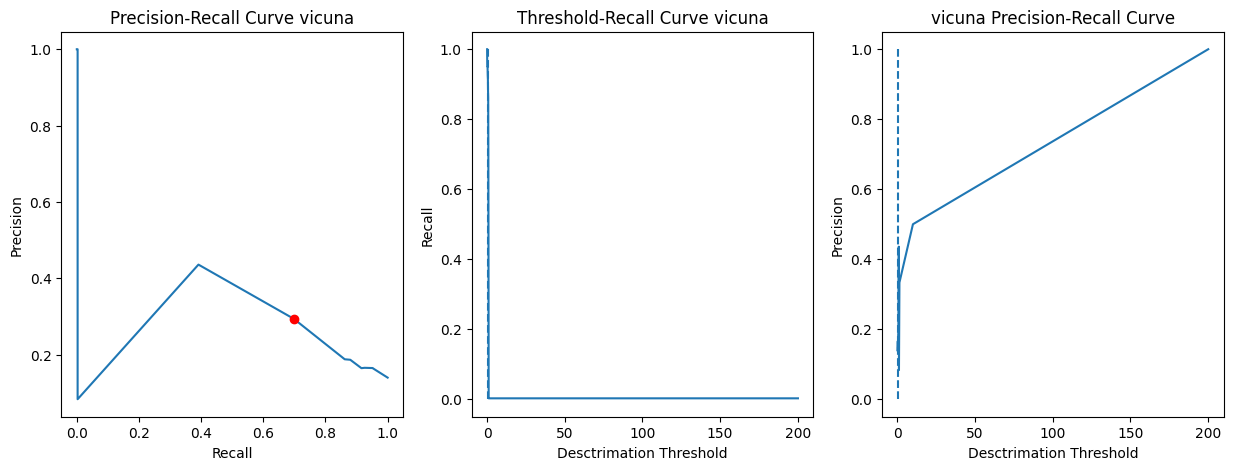

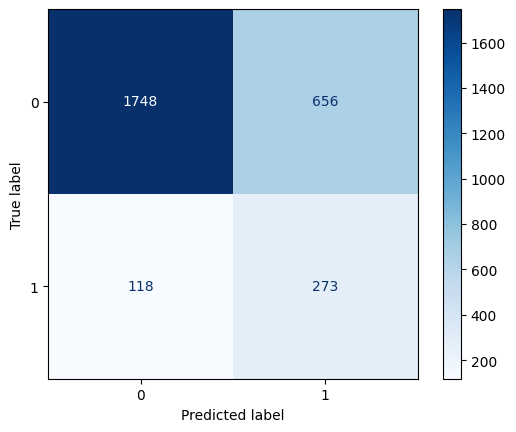

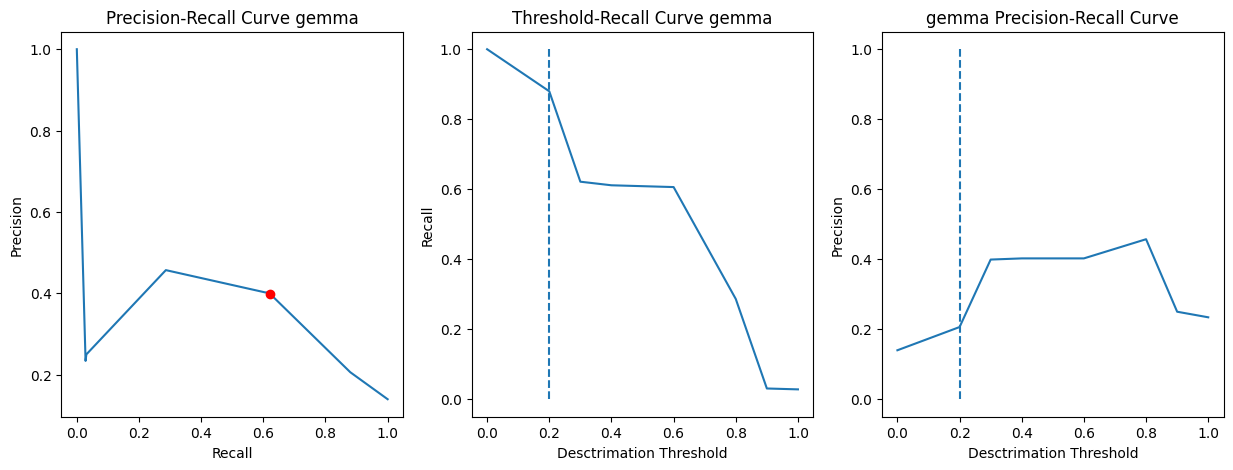

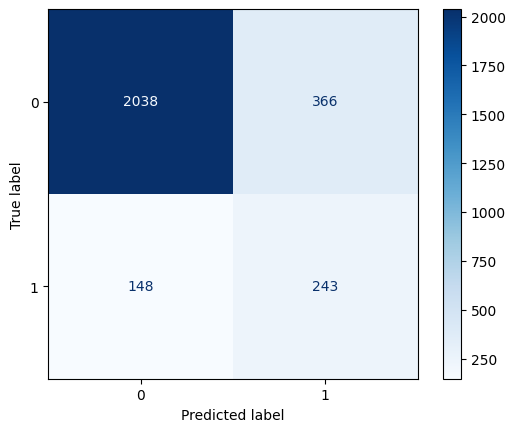

In [63]:
target_threshold=0.8
for mdls in ['mistral','openhermes','vicuna','gemma']:
    df[f'{mdls}_pred']=df[f'{mdls}_score']/10.0
    curvesplot(df['label'],df[f'{mdls}_pred'],model_name=mdls)

In [114]:
from collections import defaultdict
total=defaultdict(int)
search_phrases=list(df['search_phrase'].unique())
one_shots=[i.replace('_score','') for i in list(df.columns) if isinstance(i,str) and '_score' in i]
score=[]  
recall=[]

for i in search_phrases:
    phase_score={'search phrase':i,'precision of search phrase':df[df['search_phrase']==i]['label'].mean()}
    phase_recall={'recall of search phrase':0}
    for j in one_shots:
        y_val_proba=df[df['search_phrase']==i][f'{j}_score']
        y_value=df[df['search_phrase']==i]['label']
        threshold=find_threshold_at_recall_target(y_value,y_val_proba,recall_target=target_threshold)
        y_pred_adj=adj_class(y_val_proba,threshold)
        phase_score[f'{j} precision']=precision_score(y_value,y_pred_adj)
        phase_recall[f'{j} recall']=recall_score(y_value,y_pred_adj)
    score.append(phase_score)
    recall.append(phase_recall)
scores_df=pd.DataFrame(score)
recall_df=pd.DataFrame(recall)
scores_df 

,search phrase,precision of search phrase,mistral precision,openhermes precision,vicuna precision,gemma precision
0,mark to market accounting practices,0.180392,0.772727,0.564516,0.385542,0.446809
1,raptor creation of special purpose entities,0.148789,0.583333,0.379310,0.237500,0.454545
2,it appears that some Enron employees used dumm...,0.583578,0.991935,0.932927,0.720183,0.849057
3,record keeping accounting practices,0.254072,0.816327,0.632184,0.390625,0.555556
4,mark to market losses,0.036630,0.350000,0.153846,0.040936,0.107143
5,RANDOM,0.011278,0.666667,0.084746,0.030030,0.014469


In [122]:
phase_score={}
phase_recall={}
for j in one_shots:
    y_val_proba=df[f'{j}_score']
    y_value=df['label']
    threshold=find_threshold_at_recall_target(y_value,y_val_proba,recall_target=target_threshold)
    y_pred_adj=adj_class(y_val_proba,threshold)
    phase_score[f'{j} precision']=precision_score(y_value,y_pred_adj)
    phase_recall[f'{j} recall']=recall_score(y_value,y_pred_adj)
ds_df=pd.DataFrame([phase_score])

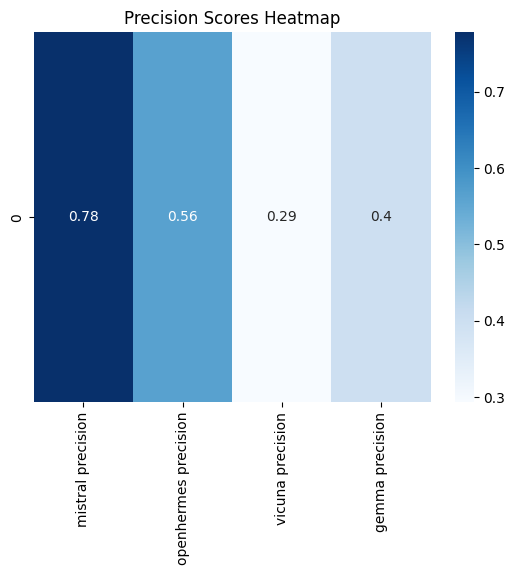

In [123]:
sns.heatmap(ds_df,annot=True, cmap='Blues')
plt.title('Precision Scores Heatmap')
plt.show()

In [115]:
scores_df.loc[2,['search phrase']]='it appears that some Enron employees used\ndummy accounts and rigged valuation\nmethodologies to create false profit-and-loss\n entries for the derivatives'

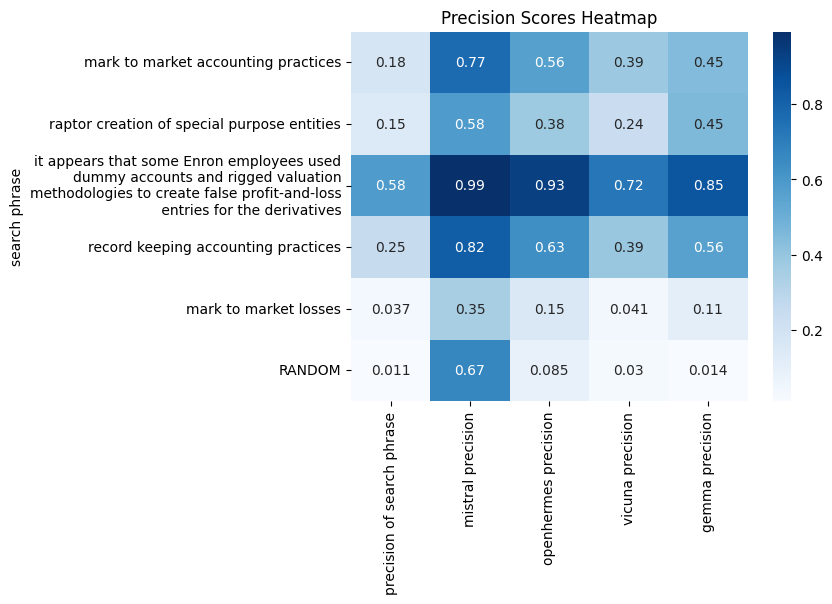

In [116]:
import seaborn as sns
scores_df.set_index('search phrase',inplace=True)
sns.heatmap(scores_df,annot=True, cmap='Blues')
plt.title('Precision Scores Heatmap')
plt.show()


In [100]:
scores_df

,search phrase,precision of search phrase,mistral precision,openhermes precision,vicuna precision,gemma precision
0,mark to market accounting practices,0.180392,0.772727,0.564516,0.385542,0.446809
1,raptor creation of special purpose entities,0.148789,0.583333,0.379310,0.237500,0.454545
2,it appears that some Enron employees used dumm...,0.583578,0.991935,0.932927,0.720183,0.849057
3,record keeping accounting practices,0.254072,0.816327,0.632184,0.390625,0.555556
4,mark to market losses,0.036630,0.350000,0.153846,0.040936,0.107143
5,RANDOM,0.011278,0.666667,0.084746,0.030030,0.014469


In [71]:
df[['search_phrase','label','email','mistral_pred','openhermes_pred','vicuna_pred','gemma_pred']].to_csv('enron_labeled_curated.csv',index=False)

In [74]:
x=pd.read_csv('../data/enron_processed.csv')

In [76]:
x.head().T


,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
MESSAGE-ID,NaN,NaN,NaN,NaN,NaN
DATE,"Mon, 14 May 2001 16:39","Fri, 4 May 2001 13:51","Wed, 18 Oct 2000 03:00","Mon, 23 Oct 2000 06:13","Thu, 31 Aug 2000 05:07"
FROM,NaN,NaN,NaN,NaN,NaN
TO,NaN,NaN,NaN,NaN,NaN
SUBJECT,NaN,Re,Re,NaN,Re
MIME-VERSION,NaN,NaN,NaN,NaN,NaN
CONTENT-TYPE,NaN,NaN,NaN,NaN,NaN
CONTENT-TRANSFER-ENCODING,NaN,NaN,NaN,NaN,NaN
body,Subject: \n\nHere is our forecast\n\n,Subject: Re:\n\nTraveling to have a business m...,Subject: Re: test\n\ntest successful. way to ...,"Subject: \n\nRandy,\n\n Can you send me a sche...",Subject: Re: Hello\n\nLet's shoot for Tuesday ...
